# 用户点赞预测

在用户对作品的浏览过程中，是否点赞是一个非常重要的指标  
通过点赞行为，可以判断出用户的喜好，评价作品的质量等。

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 20

## 1. 数据读取与处理

### 1.1 数据读取

读取数据，并保留用户特征、作品特征和是否点赞，删除其余无效字段如channel，finish， H、date（real_time中包括）

In [2]:
df = pd.read_csv('./douyin_dataset.csv')
del df['Unnamed: 0'], df['H'], df['date'], df['finish'], df['channel']
df.head()

,uid,user_city,item_id,author_id,item_city,like,music_id,duration_time,real_time
0,15692,109.0,691661,18212,213.0,0,11513.0,10,2019-10-28 21:55:10
1,44071,80.0,1243212,34500,68.0,0,1274.0,9,2019-10-21 22:27:03
2,10902,202.0,3845855,634066,113.0,0,762.0,10,2019-10-26 00:38:51
3,25300,21.0,3929579,214923,330.0,0,2332.0,15,2019-10-25 20:36:25
4,3656,138.0,2572269,182680,80.0,0,238.0,9,2019-10-21 20:46:29


In [3]:
len(df)

1737312

### 1.2 数据抽样处理

为了减少训练成本，对数据集中的数据进行抽样训练  
通过等距抽样获取部分浏览信息作为训练数据（需要同时保证点赞数据的合理比例）

In [4]:
df_like = df[df['like']==1]
df_dislike = df[df['like']==0]
data = pd.concat([df_like[::20], df_dislike[::40]], axis=0)
print(len(data)/len(df))

0.02524186789707318


### 1.3 时间数据处理

训练数据中的real_time字段包括的是字符串对象对应代表时间值，通过将其转化为与固定时间的差值(秒)来进行数值化

In [5]:
flag = pd.to_datetime('2019-01-01 00:00:00')
data['real_time'] = pd.to_datetime(data['real_time'])
data['real_time'] = pd.to_timedelta( data['real_time'] - flag).dt.total_seconds()

In [6]:
data.head()

,uid,user_city,item_id,author_id,item_city,like,music_id,duration_time,real_time
134,32039,2.0,1324665,48937,15.0,1,578.0,10,24181411.0
2181,14571,142.0,2489542,37131,229.0,1,1318.0,7,25305835.0
3955,25090,136.0,1582882,16382,69.0,1,680.0,10,23180382.0
5685,11153,73.0,209250,28248,137.0,1,4545.0,9,24856880.0
8647,2159,106.0,1019916,246,18.0,1,3928.0,9,25677638.0


### 1.4 数据集划分

In [6]:
xtrain,xtest, ytrain, ytest = \
    train_test_split(
        data.drop('like', axis=1), # X
        data['like'], # Y
        test_size=0.3,
        random_state=0 # random_seed
    )

## 2. 模型预训练

### 2.1 模型训练函数

In [7]:
def train(name, model):
    model = model.fit(xtrain, ytrain)
    print(f'{name}准确率: \t{model.score(xtest, ytest)}')
    return model

### 2.2 模型训练

In [8]:
# 逻辑回归
lgs = train('lgs', LogisticRegression(solver='liblinear', C=100.0,random_state=1))
# 朴素贝叶斯
gnb = train('gnb', GaussianNB().fit(xtrain,ytrain))
# 单棵决策树
clf = train('clf', DecisionTreeClassifier(class_weight='balanced',random_state=0))
# 随机森林
rfc = train('rfc', RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=0))

lgs准确率: 	0.9805411979325023
gnb准确率: 	0.9801611432046214
clf准确率: 	0.9601702645180906
rfc准确率: 	0.9805411979325023


### 2.3 模型ROC曲线及AUC值

AUC曲线指的是ROC曲线(Receiver Operating Characteristic curve)下的面积(Area Under the Curve)。

In [9]:
def my_auc(model):
    y_test_proba = model.predict_proba(xtest)
    false_positive_rate, recall, thresholds = roc_curve(ytest, y_test_proba[:, 1])
    roc_auc = auc(false_positive_rate, recall)
    return false_positive_rate, recall, roc_auc

In [10]:
lgs_auc = my_auc(lgs)
gnb_auc = my_auc(gnb)
clf_auc = my_auc(clf)
rfc_auc = my_auc(rfc)

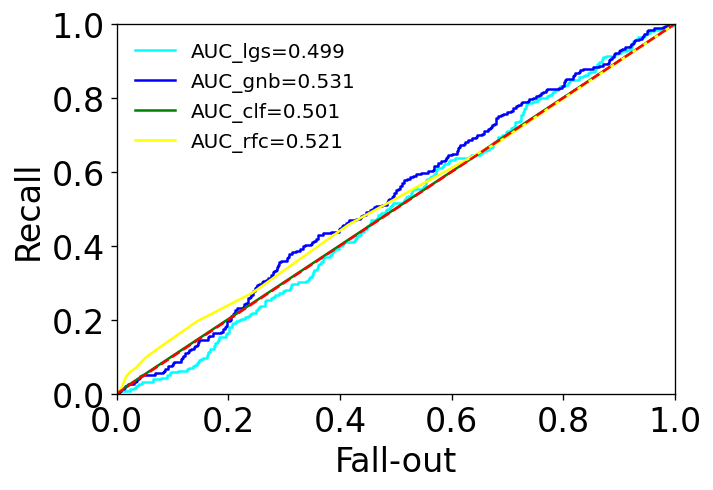

In [11]:
# 画图 画出俩模型的ROC曲线
plt.figure(figsize=(6,4),dpi=120)
plt.plot(lgs_auc[0], lgs_auc[1], color='cyan', label='AUC_lgs=%0.3f' % lgs_auc[2])
plt.plot(gnb_auc[0], gnb_auc[1], color='blue', label='AUC_gnb=%0.3f' % gnb_auc[2])
plt.plot(clf_auc[0], clf_auc[1], color='green', label='AUC_clf=%0.3f' % clf_auc[2])
plt.plot(rfc_auc[0], rfc_auc[1], color='yellow', label='AUC_rfc=%0.3f' % rfc_auc[2])
plt.legend(loc='best', fontsize=12, frameon=False)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

相对来说随机森林的效果比较好，所以选择随机森林作为二分类baseline模型

## 3. 模型优化

使用GridSearchCV模块进行格栅优化，每一个训练参数作为表格的一个维度，根据传入值，遍历格栅中每一种参数组合。
一般来说直接把多个模型参数输入即可，但是多个维度参数的组合会导致训练模型量剧增。
这里遍历了9个n_e值和10个max_f值，加上cv=3需要三折交叉，就产生了9x10x3=270次训练。因此，采用解耦的方式，把两个参数分离优化来减少训练量，达到相对较好但不是最优的效果，

In [12]:
## 需要270次的最优方法
# params = {
#     'n_estimators': [x for x in range(100,1000,100)], 
#     'max_features': range(1,20,2)
# }
# grid = GridSearchCV(
#     RandomForestClassifier(class_weight='balanced', random_state=0),
#     params, scoring="roc_auc",
#     cv=3, verbose=1, n_jobs=-1
# ).fit(xtrain, ytrain)

### 3.1 n_e优化

In [12]:
params = {
    'n_estimators': [x for x in range(100,1500,100)]
}
grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=0),
    params, scoring="roc_auc",
    cv=3, verbose=1, n_jobs=-1
).fit(xtrain, ytrain)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


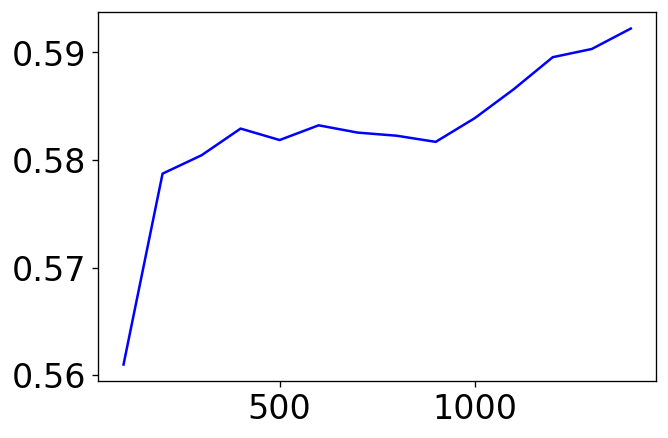

In [13]:
a = grid.cv_results_['mean_test_score']
plt.figure(figsize=(6,4),dpi=120)
plt.plot(params['n_estimators'], a, color='blue')
plt.show()

In [14]:
grid.best_params_

{'n_estimators': 1400}

选择参数为1000

### 3.2 max_f优化

In [15]:
params = {
    'max_features': range(2,10,2)
}
grid = GridSearchCV(
    RandomForestClassifier(n_estimators=1000, class_weight='balanced', random_state=0),
    params, scoring="roc_auc",
    cv=3, verbose=1, n_jobs=-1
).fit(xtrain, ytrain)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


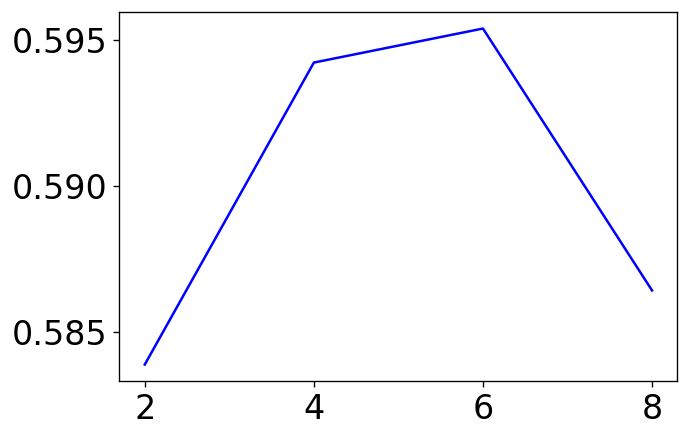

In [16]:
a = grid.cv_results_['mean_test_score']
plt.figure(figsize=(6,4),dpi=120)
plt.plot(params['max_features'], a, color='blue')
plt.show()

In [17]:
grid.best_params_

{'max_features': 6}

### 3.3 模型训练

In [18]:
rfc0 = RandomForestClassifier(n_estimators=1000,
                             max_features=6,
                             class_weight='balanced',
                             random_state=0)
rfc0 = train('rfc++', rfc0)

rfc++准确率: 	0.9805411979325023


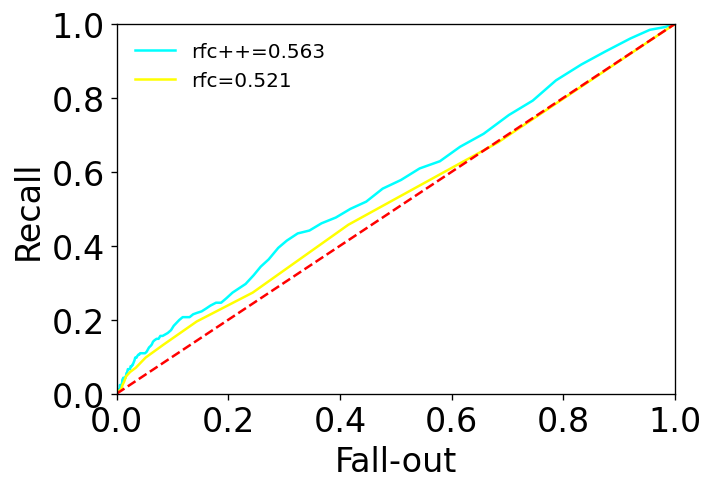

In [19]:
auc_rfc0 = my_auc(rfc0)
# 画图 画出俩模型的ROC曲线
plt.figure(figsize=(6,4),dpi=120)
plt.plot(auc_rfc0[0], auc_rfc0[1], color='cyan', label='rfc++=%0.3f' % auc_rfc0[2])
plt.plot(rfc_auc[0], rfc_auc[1], color='yellow', label='rfc=%0.3f' % rfc_auc[2])
plt.legend(loc='best', fontsize=12, frameon=False)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

## 4. 模型预测

### 4.1 模型准确率

In [20]:
df.head()

,uid,user_city,item_id,author_id,item_city,like,music_id,duration_time,real_time
0,15692,109.0,691661,18212,213.0,0,11513.0,10,2019-10-28 21:55:10
1,44071,80.0,1243212,34500,68.0,0,1274.0,9,2019-10-21 22:27:03
2,10902,202.0,3845855,634066,113.0,0,762.0,10,2019-10-26 00:38:51
3,25300,21.0,3929579,214923,330.0,0,2332.0,15,2019-10-25 20:36:25
4,3656,138.0,2572269,182680,80.0,0,238.0,9,2019-10-21 20:46:29


In [20]:
flag = pd.to_datetime('2019-01-01 00:00:00')
df['real_time'] = pd.to_datetime(df['real_time'])
df['real_time'] = pd.to_timedelta( df['real_time'] - flag).dt.total_seconds()

In [21]:
rfc0.score(df.drop('like', axis=1), df['like'])

0.9906522259674716

### 4.2 一些说明

表面上来看准确率是比较高的，但是由于斜偏类，不点赞的数据占比极高

In [22]:
lk = df['like'].value_counts()
lk

like
0    1720539
1      16773
Name: count, dtype: int64

In [23]:
lk[0]/lk.sum()

0.9903454301817981